In [36]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Perceptron
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.neural_network import MLPClassifier

from Classificadores import HebbianoWithKernel, getMeanAUC, getMeanAUC_Perceptron

In [37]:
# Importação da classificação "labels" (para todo o conjunto de dados, treinamento e teste)
data = pd.read_csv('./datasets/banknote_authentication/data_banknote_authentication.txt')
data.head()


,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [38]:
# data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [39]:
# Statistical description
data.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [40]:
# Extrai rótulos y dos atributos X

y = data['class']
y = np.array(y.replace({0:-1}))

X = np.array(data.drop(['class'], axis=1))

In [41]:
# Divide os atributos em conjunto de treinamento e de testes na razaõ 75%/ 25%
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [42]:
# Aplica a mesma escala para ambos os datasets
scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test) # note that we transform rather than fit_transform

initializing MLP kernel
Training MLP


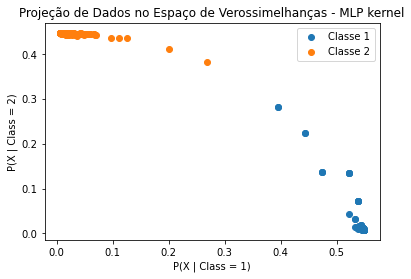

In [43]:
from kerneloptimizer.optimizer import KernelOptimizer

d = X_train_scl.shape[1]

print("initializing MLP kernel")
opt = KernelOptimizer(
    kernel='mlp',
    input_dim=d,
    hidden_dim=20,
    output_dim=50
)

print("Training MLP")
opt.fit(X_train_scl,y_train,n_epochs=100)

lspace1_train = opt.get_likelihood_space(X_train_scl, y_train)
lspace1_test  = opt.get_likelihood_space(X_test_scl, y_test)

p_classe1 = np.array(lspace1_train.loc[lspace1_train[lspace1_train.columns[0]] >= lspace1_train[lspace1_train.columns[1]]])
p_classe2 = np.array(lspace1_train.loc[lspace1_train[lspace1_train.columns[0]] <  lspace1_train[lspace1_train.columns[1]]])

# plota as verossemelhanças
plt.scatter(p_classe1[:,0], p_classe1[:,1], label = 'Classe 1')
plt.scatter(p_classe2[:,0], p_classe2[:,1], label = 'Classe 2')
plt.title('Projeção de Dados no Espaço de Verossimelhanças - MLP kernel')
plt.xlabel('P(X | Class = 1)')
plt.ylabel('P(X | Class = 2)')
plt.legend()
plt.show()

Initializing Gaussian kernel
Finding the width


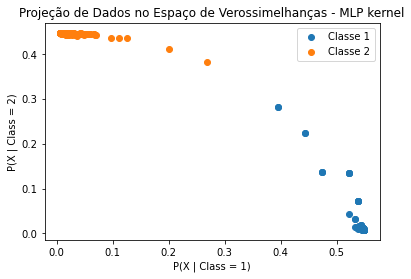

In [45]:
print("Initializing Gaussian kernel")
opt2 = KernelOptimizer(
    kernel='gaussian'
)

print("Finding the width")
opt2.fit(X,y)


lspace2_train = opt.get_likelihood_space(X_train_scl, y_train)
lspace2_test  = opt.get_likelihood_space(X_test_scl, y_test)

p_classe1 = np.array(lspace2_train.loc[lspace2_train[lspace2_train.columns[0]] >= lspace2_train[lspace2_train.columns[1]]])
p_classe2 = np.array(lspace2_train.loc[lspace2_train[lspace2_train.columns[0]] <  lspace2_train[lspace2_train.columns[1]]])


# plota as verossemelhanças
plt.scatter(p_classe1[:,0], p_classe1[:,1], label = 'Classe 1')
plt.scatter(p_classe2[:,0], p_classe2[:,1], label = 'Classe 2')
plt.title('Projeção de Dados no Espaço de Verossimelhanças - MLP kernel')
plt.xlabel('P(X | Class = 1)')
plt.ylabel('P(X | Class = 2)')
plt.legend()
plt.show()

### Hebbiano Com Kernel

In [13]:
kernels = ['mlp', 'gaussian']

parameters = {'kernel': kernels}
model = HebbianoWithKernel()

clf = GridSearchCV(model, parameters, scoring='roc_auc', n_jobs = -1, cv = 10)
clf.fit(X_train_scl, y_train)

GridSearchCV(cv=10, estimator=HebbianoWithKernel(), n_jobs=-1,
             param_grid={'kernel': ['mlp', 'gaussian']}, scoring='roc_auc')

In [17]:
idx = np.where(clf.cv_results_['mean_test_score'] == np.amax(clf.cv_results_['mean_test_score']))[0][0]
best_score = clf.cv_results_['mean_test_score'][idx]
best_score_std = clf.cv_results_['std_test_score'][idx]

best_kernel= clf.best_params_['kernel']


print('Ao utilizar kernel {} foi atingindo a melhor acurácia média de validação cruzada sobre o conjunto de treinamento: {} +/- {}%'.format(best_kernel, round(best_score*100,3), round(best_score_std*100, 3)))

Ao utilizar kernel mlp foi atingindo a melhor acurácia média de validação cruzada sobre o conjunto de treinamento: 100.0 +/- 0.0%


In [32]:
iterations = 10

aucs = np.zeros(iterations)
Accuracy_array = np.zeros(execucoes)

for i in range(iterations):
    classifier_model = HebbianoWithKernel(kernel = best_kernel)
    classifier_model.fit(X_train_scl, y_train)
    y_pred = classifier_model.predict(X_test_scl)
    aucs[i] = roc_auc_score(y_test, y_pred)
    Accuracy_array[i] = accuracy_score(y_test, y_pred)


print('AUC médio e desvio padrão sobre o conjunto de testes após dez tentativas {} +/- {}'.format(round(np.mean(aucs),3), round(np.std(aucs),3)))
print('Acurácia média e desvio padrão sobre o conjunto de testes após dez,tentativas {} +/- {}'.format(round(np.mean(Accuracy_array),3), round(np.std(Accuracy_array),3)))

AUC médio e desvio padrão sobre o conjunto de testes após dez tentativas 1.0 +/- 0.0
Acurácia média e desvio padrão sobre o conjunto de testes após dez,tentativas 1.0 +/- 0.0


### MLP

In [23]:
NNeuronios = [(2,), (4,), (8,), (16,), (32,), (64,), (128,), (256,), (512,), (1024,), (2048,)]
activations = ['identity', 'logistic', 'tanh', 'relu']
parameters = {'hidden_layer_sizes':NNeuronios, 'activation':activations}
model = MLPClassifier()
clf = GridSearchCV(model, parameters, scoring='roc_auc', n_jobs = -1, cv = 10)
clf.fit(X_train_scl, y_train)

C:\Users\Leonam\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=10, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(2,), (4,), (8,), (16,), (32,),
                                                (64,), (128,), (256,), (512,),
                                                (1024,), (2048,)]},
             scoring='roc_auc')

In [25]:
idx = np.where(clf.cv_results_['mean_test_score'] == np.max(clf.cv_results_['mean_test_score']))[0][0]
best_AUC = clf.cv_results_['mean_test_score'][idx]
best_AUC_std = clf.cv_results_['std_test_score'][idx]

best_Nneuronios = clf.best_params_['hidden_layer_sizes'][0]
best_activation = clf.best_params_['activation']

print('Ao utilizar {} neurônios na camada intermediária e função de ativação {} foi encontrado o maior AUC médio de validação cruzada sobre o conjunto de treinamento: {} +/- {}%'.format(best_Nneuronios, best_activation, round(best_AUC,3), round(best_AUC_std, 3)))

Ao utilizar 32 neurônios na camada intermediária e função de ativação relu foi encontrado o maior AUC médio de validação cruzada sobre o conjunto de treinamento: 1.0 +/- 0.0%


In [31]:
execucoes = 10
AUC_array = np.zeros(execucoes)
Accuracy_array = np.zeros(execucoes)
for i in range(execucoes):
    classifier_model = MLPClassifier(hidden_layer_sizes=best_Nneuronios,activation=best_activation, max_iter=2000)
    classifier_model.fit(X_train_scl, y_train)
    y_pred = classifier_model.predict(X_test_scl)
    AUC_array[i] = roc_auc_score(y_test, y_pred)
    Accuracy_array[i] = accuracy_score(y_test, y_pred)

print('AUC médio e desvio padrão sobre o conjunto de testes após dez tentativas {} +/- {}'.format(round(np.mean(AUC_array),3), round(np.std(AUC_array),3)))
print('Acurácia média e desvio padrão sobre o conjunto de testes após dez,tentativas {} +/- {}'.format(round(np.mean(Accuracy_array),3), round(np.std(Accuracy_array),3)))

AUC médio e desvio padrão sobre o conjunto de testes após dez tentativas 1.0 +/- 0.0
Acurácia média e desvio padrão sobre o conjunto de testes após dez,tentativas 1.0 +/- 0.0
